# Column Definition
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass		Ticket class	1 = 1st = Upper, 2 = 2nd = Middle, 3 = 3rd = Lower
sex			Sex	
Age			Age in years (fractional if less than 1. If the age is estimated, is it in the form of xx.5)
sibsp		# of siblings / spouses aboard the Titanic
	Sibling = brother, sister, stepbrother, stepsister
	Spouse = husband, wife (mistresses and fiancés were ignored)
parch		# of parents / children aboard the Titanic	
	Parent = mother, father
	Child = daughter, son, stepdaughter, stepson
	Some children travelled only with a nanny, therefore parch=0 for them.
ticket		Ticket number	
fare		Passenger fare	
cabin		Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

# Import Packages

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import os
plt.style.use('ggplot')

# Load File

In [2]:
# make python folder your current working directory
if os.path.isdir('python'):
	os.chdir('python')

In [3]:
# Load titanic data frame, create new columns 'dataset' then concatenate the 2 data
titanic_train = pd.read_csv('train.csv')
titanic_test = pd.read_csv('test.csv')

titanic_train['dataset'] = 'train'
titanic_test['dataset'] = 'test'

df = [titanic_train, titanic_test]
titanic = pd.concat(df)

# EDA and Cleaning

In [4]:
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,dataset
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,train
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,train
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,train
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,train
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,train


# Import Packages

In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dataset        1309 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 143.2+ KB


In [6]:
titanic.describe()

C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,328.000000,2.000000,0.000000,NaN
50%,NaN,NaN,0.000000,655.000000,3.000000,0.000000,NaN
75%,NaN,NaN,0.000000,982.000000,3.000000,1.000000,NaN
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


In [7]:
def change_col(data):
    new_col = [i.lower().replace(' ','_').replace('#','no') for i in data.columns]
    data.columns = new_col
    return data

In [8]:
titanic = change_col(titanic)
titanic.columns

Index(['age', 'cabin', 'embarked', 'fare', 'name', 'parch', 'passengerid',
       'pclass', 'sex', 'sibsp', 'survived', 'ticket', 'dataset'],
      dtype='object')

Create new columns for name (fname, lname, title)

In [9]:
# Create new columns based on names (LastName, FirstName and Title)
titanic['name_split'] = titanic.name.str.split('\, ')
titanic['lname'] = titanic.name_split.str.get(0)
titanic['fname'] = titanic.name_split.str.get(1)
titanic['fname'] = titanic.fname.str.split('\. ')
titanic['title'] = titanic.fname.str.get(0)
titanic['fname'] = titanic.fname.str.get(1)
del titanic['name_split']

Check for NULL fare since info above stated that there is 1 missing fare

In [10]:
# Fare, since the fare cannot be know due to also missing cabin location, we can just remove this
titanic.loc[titanic.fare.isnull()]

,age,cabin,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket,dataset,lname,fname,title
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,test,Storey,Thomas,Mr


In [11]:
# Dropping NULL fares since it will not affect our analysis
titanic = titanic.loc[titanic.fare.notnull()]

Since there are many values that are missing for Cabin, let us forget about it for now and focus on other columns. Let us create a Gender column separating the Male, Female and Child passengers.

In [12]:
def male_female_child(passenger):
    age, sex = passenger
    if age < 14:
        return 'child'
    else:
        return sex    

In [13]:
titanic['gender'] = titanic[['age','sex']].apply(male_female_child,axis=1)

Getting value for embarked, checking as there are 2 NULLs found.

In [14]:
tfare = titanic.loc[titanic.embarked.isnull(),'fare'].mean()
titanic.loc[(titanic.fare > (tfare-2.0)) & (titanic.fare < (tfare+2.0)) & (titanic.cabin.str[0] == 'B')]

,age,cabin,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket,dataset,lname,fname,title,gender
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,train,Icard,Amelie,Miss,female
139,24.0,B86,C,79.2,"Giglio, Mr. Victor",0,140,1,male,0,0.0,PC 17593,train,Giglio,Victor,Mr,male
587,60.0,B41,C,79.2,"Frolicher-Stehli, Mr. Maxmillian",1,588,1,male,1,1.0,13567,train,Frolicher-Stehli,Maxmillian,Mr,male
789,46.0,B82 B84,C,79.2,"Guggenheim, Mr. Benjamin",0,790,1,male,0,0.0,PC 17593,train,Guggenheim,Benjamin,Mr,male
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,train,Stone,George Nelson (Martha Evelyn),Mrs,female
397,48.0,B41,C,79.2,"Frolicher-Stehli, Mrs. Maxmillian (Margaretha ...",1,1289,1,female,1,NaN,13567,test,Frolicher-Stehli,Maxmillian (Margaretha Emerentia Stehli),Mrs,female


In [15]:
# Setting value to C as found in above results
titanic.loc[titanic.embarked.isnull(),'embarked'] = 'C'
titanic.embarked.groupby(titanic.embarked).count()

embarked
C    272
Q    123
S    913
Name: embarked, dtype: int64

Adding new column for those people with Family and those that travelled alone.

In [16]:
titanic['w_family'] = titanic.parch + titanic.sibsp
titanic.loc[titanic.w_family > 0,'w_family'] = 'with family'
titanic.loc[titanic.w_family == 0,'w_family'] = 'alone'

In [17]:
titanic['w_family'].value_counts()

alone          789
with family    519
Name: w_family, dtype: int64

In [18]:
titanic.cabin.str[0].groupby(titanic.cabin.str[0]).count()

cabin
A    22
B    65
C    94
D    46
E    41
F    21
G     5
T     1
Name: cabin, dtype: int64

In [19]:
titanic['cabin_letter'] = titanic.cabin.str[0]

In [20]:
titanic.title.value_counts()

Mr              756
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Ms                2
Mlle              2
Mme               1
Don               1
Sir               1
Lady              1
Jonkheer          1
Dona              1
Capt              1
the Countess      1
Name: title, dtype: int64

In [21]:
filt = ['Mr','Mrs','Miss','Master']
titanic.loc[~titanic.title.isin(filt),'title'].value_counts()

Rev             8
Dr              8
Col             4
Ms              2
Mlle            2
Major           2
Dona            1
Don             1
Sir             1
Capt            1
Jonkheer        1
Lady            1
Mme             1
the Countess    1
Name: title, dtype: int64

In [22]:
title_new = titanic.title.copy()

In [23]:
#Change Ms and Mlle to Miss
title_new[title_new.isin(['Ms','Mlle'])] = 'Miss' 
title_new[title_new == 'Mme'] = 'Mrs'
title_new[~title_new.isin(filt)] = 'Honorifics'
title_new.value_counts()

Mr            756
Miss          264
Mrs           198
Master         61
Honorifics     29
Name: title, dtype: int64

In [24]:
titanic.loc[:,'new_title'] = title_new
titanic.loc[np.logical_and(titanic.new_title == 'Honorifics',
                                 titanic.sex == 'male'),'new_title'] = 'Honorific_male'
titanic.loc[np.logical_and(titanic.new_title == 'Honorifics',
                                 titanic.sex == 'female'),'new_title'] = 'Honorific_female'

# Separate Train and Test Data

In [25]:
#Separate Train Data with Test Data
titanic_train = titanic.loc[titanic['dataset'] == 'train']
titanic_test = titanic.loc[titanic['dataset'] == 'test']

data = titanic_train

In [26]:
titanic_train.head()

,age,cabin,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket,dataset,lname,fname,title,gender,w_family,cabin_letter,new_title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,train,Braund,Owen Harris,Mr,male,with family,NaN,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,train,Cumings,John Bradley (Florence Briggs Thayer),Mrs,female,with family,C,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,train,Heikkinen,Laina,Miss,female,alone,NaN,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,train,Futrelle,Jacques Heath (Lily May Peel),Mrs,female,with family,C,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,train,Allen,William Henry,Mr,male,alone,NaN,Mr


In [27]:
titanic_test.head()

,age,cabin,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket,dataset,lname,fname,title,gender,w_family,cabin_letter,new_title
0,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,NaN,330911,test,Kelly,James,Mr,male,alone,NaN,Mr
1,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,NaN,363272,test,Wilkes,James (Ellen Needs),Mrs,female,with family,NaN,Mrs
2,62.0,NaN,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,male,0,NaN,240276,test,Myles,Thomas Francis,Mr,male,alone,NaN,Mr
3,27.0,NaN,S,8.6625,"Wirz, Mr. Albert",0,895,3,male,0,NaN,315154,test,Wirz,Albert,Mr,male,alone,NaN,Mr
4,22.0,NaN,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,female,1,NaN,3101298,test,Hirvonen,Alexander (Helga E Lindqvist),Mrs,female,with family,NaN,Mrs


# Creating EDA for Train

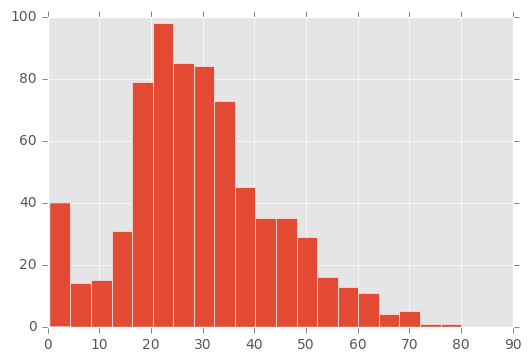

In [28]:
# Clean columns, check age column first
plt.hist(data.age[titanic_train.age > 0], bins = 20)
plt.show()

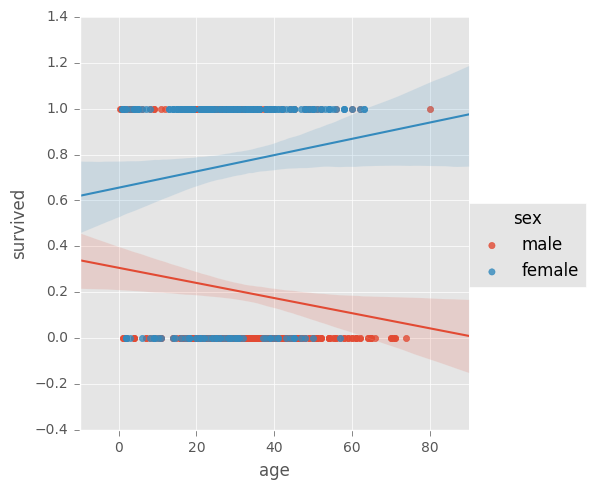

In [29]:
#It can be seen here that female has positive linear regression while male has negative,
# suggests that as male age increases chance of survival decreases and this is vice versa for females
sns.lmplot(x='age', y='survived', hue = 'sex', data = data)
plt.show()

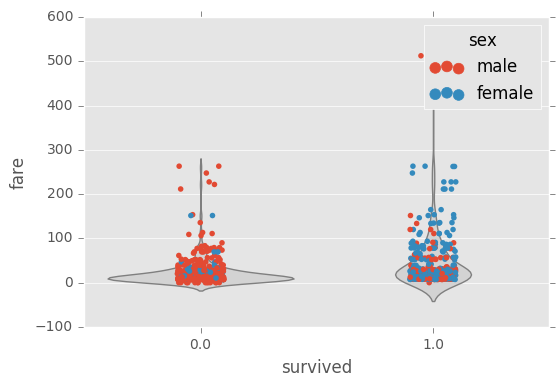

In [30]:
#Shows that fare might be a little bit related to survival as there are more survivors in higher fares
sns.violinplot(x = 'survived', y = 'fare', data = data, inner = None, color = 'lightgray')
sns.stripplot(x = 'survived', y = 'fare', data = data, size = 4, jitter= True, hue = 'sex')
plt.show()

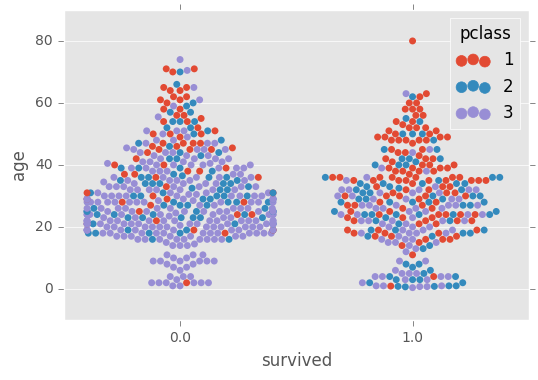

In [31]:
# Plotting Survival with age, there are many 20 plus people that did not make it, 
# as for Pclass, a lot of class 3 passenger were not able to survive the tragedy.
sns.swarmplot(x = 'survived', y = 'age', data = data, hue = 'pclass')
plt.show()

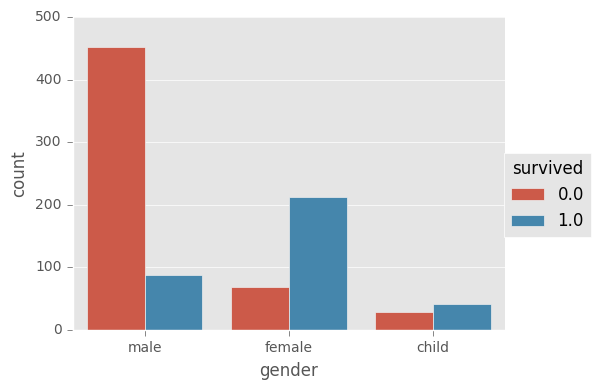

In [32]:
# Gender and Survived Plot.
sns.factorplot('gender', hue = 'survived', data = data, kind = 'count', aspect = 1.25)
plt.show()

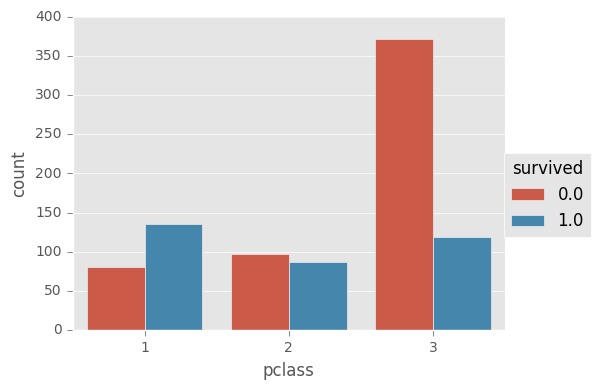

In [33]:
# Pclass and Survived
sns.factorplot('pclass', hue = 'survived', data = data, kind = 'count', aspect = 1.25)
plt.show()

In [34]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x,y)
    # Return entry [0,1]
    return corr_mat[0,1]

Data above suggests that age increase does not affect survival that much, it must be that there are more middle aged people that have survived than older ones.

In [35]:
print(pearson_r(x= data.age.notnull(), y = data['survived']))
print(pearson_r(x= data.pclass, y = data['survived']))

0.0921965232422
-0.338481035961


Plot below suggests and confirms that more middle aged people did not survived, as well as that there are more people in class 3 that did not survived,

In [36]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [37]:
perm_samp_pclass, perm_samp_survived = permutation_sample(data.pclass, data.survived)

In [38]:
# Compute observed correlation: r_obs
r_obs = pearson_r(data.pclass, titanic_train.survived)

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(100000)

# Draw replicates
for i in range(100000):
    # Permute illiteracy measurments: illiteracy_permuted
    survived_permuted = np.random.permutation(data.survived)

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(data.pclass, survived_permuted)

# Compute p-value: p
p = np.sum(perm_replicates <= r_obs) / len(perm_replicates)

print('p-val =', p)

p-val = 0.0


In [39]:
# Load functions
def ecdf(col):
	"""Compute ECDF for a one-dimensional array of measurements."""
	n = len(col) # Number of data points: n
	x = np.sort(col) # x-data for the ECDF: x
	y = np.arange(1, n+1) / float(n) # y-data for the ECDF: y
	return x,y

It is seen below that the value of Pearson Correlation coefficient is very low compared to the permutated sample, this suggest that indeed pclass might be negatively correlated to the value of survived.

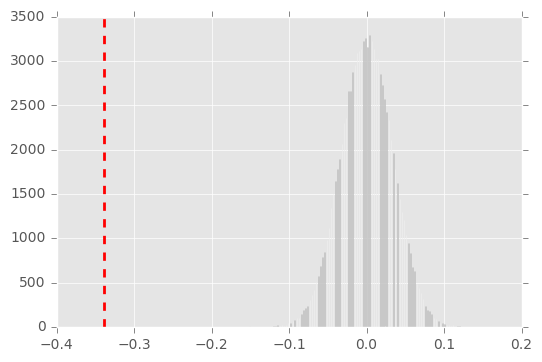

In [40]:
plt.hist(perm_replicates, bins = 500 ,color= 'black')
plt.axvline(r_obs, color = 'r', linestyle = 'dashed', linewidth = 2)
plt.show()

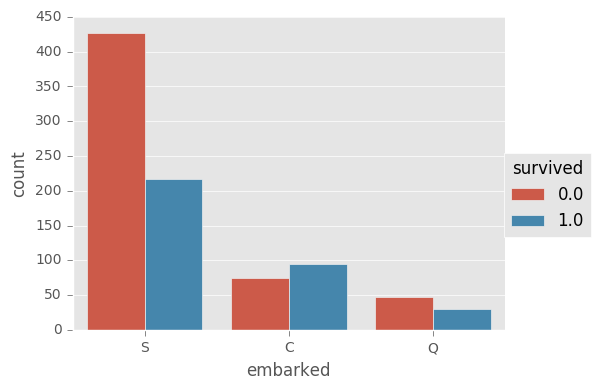

In [41]:
sns.factorplot('embarked', hue = 'survived', data = data, kind = 'count', aspect = 1.25)
plt.show()

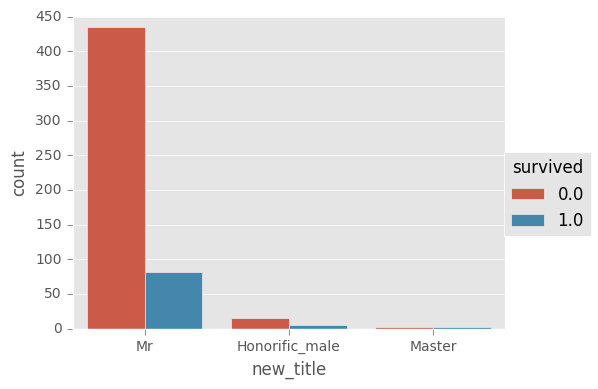

In [42]:
sns.factorplot('new_title', hue = 'survived', data = data[data.gender == 'male'], kind = 'count', aspect = 1.25)
plt.show()

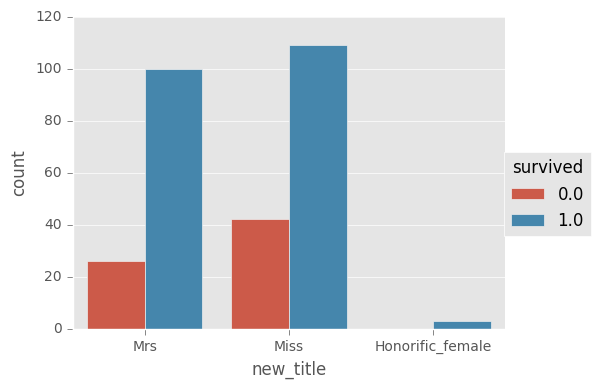

In [43]:
sns.factorplot('new_title', hue = 'survived', data = data[data.gender == 'female'], kind = 'count', aspect = 1.25)
plt.show()

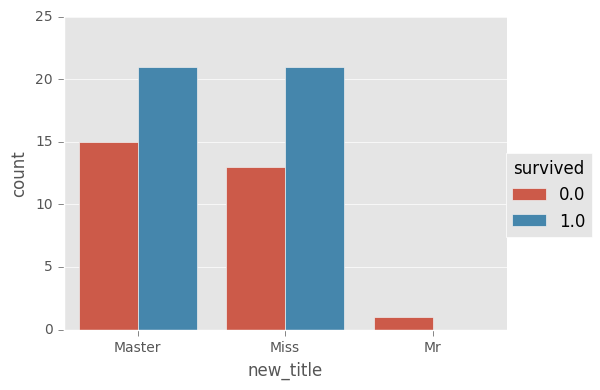

In [44]:
sns.factorplot('new_title', hue = 'survived', data = data[data.gender == 'child'], kind = 'count', aspect = 1.25)
plt.show()

## Preparing to make the Prediction Model

Now checking for Passenger Title, it can be seen below that some of the passengers have different title, it might needed to be grouped for better analysis.  

In [45]:
data = data.loc[data.age.notnull()]

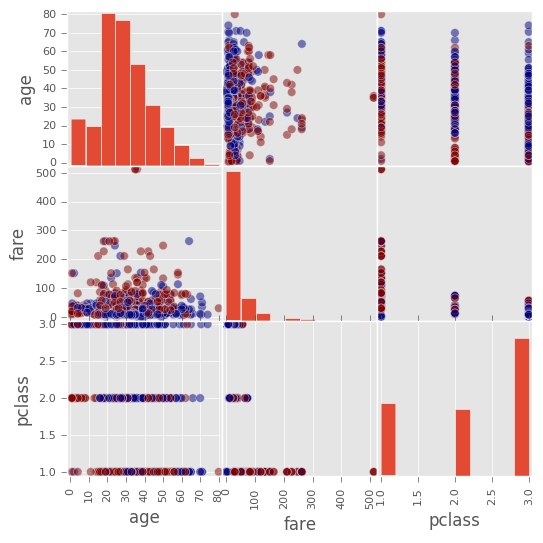

In [46]:
_ = pd.scatter_matrix(data.loc[:,['age','fare','pclass']], c = data.survived, figsize = [6,6],
                      s = 150, marker = '.')
plt.show()

In [47]:
data_dummy = data.loc[:,['age','embarked','fare','gender','w_family','new_title','cabin_letter','survived']]
data_dummy = pd.get_dummies(data_dummy, drop_first = True)
data_dummy.info()
#print(data.gender_no.value_counts())
#print(data.title_no.value_counts())
#print(data.embarked_no.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 20 columns):
age                         714 non-null float64
fare                        714 non-null float64
survived                    714 non-null float64
embarked_Q                  714 non-null float64
embarked_S                  714 non-null float64
gender_female               714 non-null float64
gender_male                 714 non-null float64
w_family_with family        714 non-null float64
new_title_Honorific_male    714 non-null float64
new_title_Master            714 non-null float64
new_title_Miss              714 non-null float64
new_title_Mr                714 non-null float64
new_title_Mrs               714 non-null float64
cabin_letter_B              714 non-null float64
cabin_letter_C              714 non-null float64
cabin_letter_D              714 non-null float64
cabin_letter_E              714 non-null float64
cabin_letter_F              714 non-null float64
cabin_letter_

In [48]:
data_test = titanic_test.loc[titanic_test.age.notnull()]
data_test = data_test.sort_values(by='name')
data_test = data_test.reset_index()

In [49]:
data_test_dummy = data_test.loc[:,['age','embarked','fare','gender','w_family','new_title','cabin_letter']]
data_test_dummy = pd.get_dummies(data_test_dummy, drop_first = True)
data_test_dummy.loc[:,'cabin_letter_T'] = 0
data_test_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 19 columns):
age                         331 non-null float64
fare                        331 non-null float64
embarked_Q                  331 non-null float64
embarked_S                  331 non-null float64
gender_female               331 non-null float64
gender_male                 331 non-null float64
w_family_with family        331 non-null float64
new_title_Honorific_male    331 non-null float64
new_title_Master            331 non-null float64
new_title_Miss              331 non-null float64
new_title_Mr                331 non-null float64
new_title_Mrs               331 non-null float64
cabin_letter_B              331 non-null float64
cabin_letter_C              331 non-null float64
cabin_letter_D              331 non-null float64
cabin_letter_E              331 non-null float64
cabin_letter_F              331 non-null float64
cabin_letter_G              331 non-null float64
cabin_letter_

In [50]:
X = data_dummy.drop('survived',axis = 1)
y = data_dummy.survived
test_X = data_test_dummy

## Creating the actual prediction model for Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

In [52]:
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.43939705607607948}
Best score is 0.7815126050420168


In [53]:
logreg = LogisticRegression(C = 0.43939705607607948)
logreg.fit(X,y)
logpred = logreg.predict(test_X)

In [54]:
data_test.loc[:,'survived_logreg'] = logpred

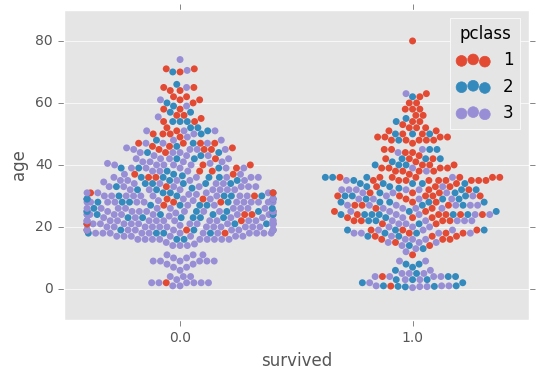

In [55]:
sns.swarmplot(x = 'survived', y = 'age', data = data, hue = 'pclass')
plt.show()

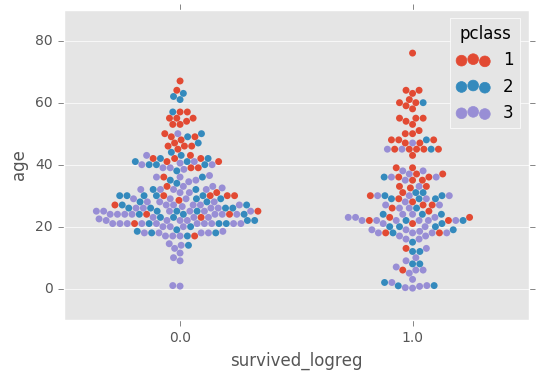

In [56]:
sns.swarmplot(x = 'survived_logreg', y = 'age', data = data_test, hue = 'pclass')
plt.show()

### Checking Accuracy
Actual data for Titanic Dataset was acquired on https://www.encyclopedia-titanica.org/titanic-survivors/

Checking how the prediction model was able to fare up against the actual records.

In [58]:
# Data is acquired online
titanicOnline = pd.read_csv('test_set.csv')
titanicOnline = titanicOnline.loc[np.logical_and(titanicOnline.Age.notnull(),titanicOnline.Fare.notnull()), ['PassengerID', 'Pclass','Name','Sex','Age','Fare','Embarked','Survived']]

In [59]:
titanic_val = titanicOnline.loc[:,['Name','Survived']].sort_values(by='Name')
titanic_val = titanic_val.reset_index()

In [60]:
data_test_logreg = data_test.sort_values(by='name')
data_test_logreg = data_test_logreg.reset_index()

validate_2 = np.empty(len(data_test_logreg))
for x in np.arange(len(data_test_logreg)):
    validate_2[x] = (data_test_logreg.loc[x,'survived_logreg'] == titanic_val.loc[x,'Survived'])

In [61]:
# Using Logistic Regression Instead of KNN, value for accuracy is higher.
logreg.score(test_X, titanic_val.Survived)

0.6797583081570997

In [62]:
np.sum(validate_2)/len(validate_2)

0.6797583081570997